# Evaluation of Perturbations/Randomizations of Data
I conducted experiments in which I perturbed the original data I was using. This notebook computes and plots PR curves from the different perturbations of:
* **the PPI network**. I randomly shuffled 50% or 100% of the edges, preserving the node degree. I also added two random networks, one that preserves the node degree and one that doesn't.
* **the multi-omics features**. I again shuffled 50% or 100% of the node features around. I also added random features (twice to match with the number of perturbations with networks).
* **both of them**. I also created containers where I perturbed both, features and the network.

I expect the performance to drop when the data becomes less informative and more random. At the same time, we know that the study bias of cancer genes is quite high so that I expect much more extreme drops in performance when the node degree is not preserved. The random network with maintained node degree should give us a nice baseline here.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os, sys

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

sys.path.append(os.path.abspath('../GCN'))
import gcnIO
import postprocessing

sys.path.append(os.path.abspath('../pagerank'))
import pagerank

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Helvetica')

%matplotlib inline

## Parameters

* `perturbation_to_analyse`: Which of the perturbations we are currently looking at. Can be any of:
    1. _network_ for analysis of network perturbations
    2. _features_ for analysis of feature perturbations
    3. _netfeat_ for analysis of both, network and feature perturbations at the same time

In [2]:
perturbation_to_analyse = 'features'

## Functions

In [3]:
#perturbation_folder = '../data/GCN/training/perturbation_{}/'.format(perturbation_to_analyse)
perturbation_folder = '../data/GCN/training/2019_08_26_11_26_22/' # features CPDB new
#perturbation_folder = '../data/GCN/training/2019_08_27_11_32_33/' # network CPDB new
#perturbation_folder = '../data/GCN/training/2019_08_29_11_25_15/' # netfeat CPDB new
#perturbation_folder = '../data/GCN/training/2019_11_06_17_54_54/'

In [4]:
def _get_printable_name(raw_name):
    if raw_name.startswith('0_5_'):
        return "50% Edited"
    elif raw_name.startswith('0_'):
        return "Original"
    elif raw_name.startswith('1_'):
        return "100% Edited"
    elif raw_name.startswith('Random_degreepreserved'):
        return "Random\n(exp. Degree)"
    elif raw_name.startswith('Random_powerlaw'):
        return "Random\n(Power Law)"
    else:
        return raw_name

def _performance(y_true, y_score, metric='aupr'):
    if metric.upper() == 'AUPR':
        pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
        aupr = average_precision_score(y_true=y_true, y_score=y_score)
        return pr, rec, aupr
    elif metric.upper() == 'ROC':
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
        auroc = roc_auc_score(y_true=y_true, y_score=y_score)
        return tpr, fpr, auroc

def GCN_performance(train_dir, metric='aupr', cv_all=False):
    args, data_file = gcnIO.load_hyper_params(train_dir)
    data = gcnIO.load_hdf_data(data_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    predictions = postprocessing.load_predictions(train_dir)
    pred_testset = predictions[predictions.Name.isin(node_names[test_mask, 1])]
    if cv_all:
        predictions = pd.read_csv(os.path.join(train_dir, 'ensemble_predictions.tsv'),
                                            sep='\t', header=0, index_col=0)
        nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
        nodes = nodes[~nodes.index.duplicated()]
        pred = predictions[~predictions.index.duplicated()]
        pred.reindex(index=nodes.index)
        pred_test = pred[pred.Name.isin(node_names[test_mask, 1])]
        
        num_cvs = len([i for i in pred.columns if i.startswith('Prob_pos_')])
        performances = []
        for cv_run in range(num_cvs):
            performances.append(_performance(pred_test.label, pred_test['Prob_pos_{}'.format(cv_run+1)]))
        return performances
    else:
        return _performance(pred_testset.label, pred_testset.Prob_pos, metric)

def rf_performance(train_dir, metric='aupr'):
    args, data_file = gcnIO.load_hyper_params(train_dir)
    data = gcnIO.load_hdf_data(data_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    
    # prepare the data for sklearn API
    X_train = features[train_mask.astype(np.bool)]
    y_train_rf = y_train[train_mask.astype(np.bool)]
    X_test = features[test_mask.astype(np.bool)]
    y_test_rf = y_test[test_mask.astype(np.bool)]
    
    # train RF on the data and predict for testset
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train_rf.reshape(-1))
    pred_testset = rf.predict_proba(X_test)

    y_true = y_test[test_mask == 1, 0]
    return _performance(y_true, pred_testset[:, 1], metric)

def pagerank_performance(train_dir, metric='aupr'):
    args, data_file = gcnIO.load_hyper_params(train_dir)
    data = gcnIO.load_hdf_data(data_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    y_true = y_test[test_mask == 1, 0]
    
    # run pagerank on the data
    scores, names = pagerank.pagerank(network, node_names)
    pr_df = pd.DataFrame(scores, columns=['Number', 'Score']) # get the results in same order as our data
    names = pd.DataFrame(names, columns=['ID', 'Name'])
    pr_pred_all = pr_df.join(names, on='Number', how='inner')
    pr_pred_all.drop_duplicates(subset='Name', inplace=True)
    node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    pr_pred_all = pr_pred_all.set_index('Name').reindex(node_names_df.Name)
    pr_pred_test = pr_pred_all[pr_pred_all.index.isin(node_names[test_mask == 1, 1])]
    pr_pred_test.drop_duplicates(inplace=True)
    
    return _performance(y_true, pr_pred_test.Score)

def get_all_metrics(perturbation_dir, func=GCN_performance, kind='aupr', cv_auc_vals=False):
    all_perfs = []
    for training in os.listdir(perturbation_dir):
        if not training.startswith('.') and os.path.isdir(os.path.join(perturbation_dir, training)):
            if os.path.isfile(os.path.join(perturbation_dir, training, 'hyper_params.txt')):
                print (training)
                if cv_auc_vals:
                    aucs = [i[2] for i in func(os.path.join(perturbation_dir, training), metric=kind, cv_all=True)]
                    all_perfs.append((aucs, training))
                    print ("Network: {}\tAUPR: {}".format(_get_printable_name(training), np.mean(aucs)))
                else:
                    pr, rec, aupr = func(os.path.join(perturbation_dir, training), metric=kind)
                    all_perfs.append((pr, rec, aupr, training))
                    print ("Network: {}\tAUPR: {}".format(_get_printable_name(training), aupr))
    return all_perfs

def plot_curve(values, method_name='GCN', kind='PR', save_path=None, linewidth = 4, labelfontsize = 20, ticksize = 17, label_rotation=0, figsize=(14, 8)):
    fig = plt.figure(figsize=figsize)
    
    if 'SWARM' in kind.upper():
        df = pd.DataFrame([i[0] for i in values],
                          index=[i[1] for i in values],
                          columns=['CV_{}'.format(i) for i in range(len(values[0][0]))]
                         )
        df['perturbation'] = [_get_printable_name(i) for i in df.index]
        long = df.melt(id_vars=['perturbation'])
        sns.violinplot(data=long, x='perturbation', y='value')
        sns.swarmplot(data=long, x='perturbation', y='value', color='white', edgecolor='darkgray')#, hue='variable')
    elif 'BOX' in kind.upper():
        df = pd.DataFrame([i[0] for i in values],
                          index=[i[1] for i in values],
                          columns=['CV_{}'.format(i) for i in range(len(values[0][0]))]
                         )
        df['perturbation'] = [_get_printable_name(i) for i in df.index]
        long = df.melt(id_vars=['perturbation'])
        sns.boxplot(data=long, x='perturbation', y='value')
    else:
        for y, x, auc, name in values:
            plt.plot(x, y, lw=linewidth, label='{0} ({1}) (AUC = {2:.2f})'.format(method_name, _get_printable_name(name), auc))
    if kind.upper() == 'PR':
        plt.xlabel('Recall', fontsize=labelfontsize)
        plt.ylabel('Precision', fontsize=labelfontsize)
        plt.legend(fontsize=labelfontsize)
    elif kind.upper() == 'ROC':
        plt.xlabel('False Positive Rate', fontsize=labelfontsize)
        plt.ylabel('True Positive Rate', fontsize=labelfontsize)
        plt.legend(fontsize=labelfontsize)
    elif kind.upper() == 'SWARM':
        plt.xlabel('')
        plt.ylabel('AUPR', fontsize=labelfontsize)
    plt.tick_params(axis='both', labelsize=ticksize)
    plt.tick_params(axis='x', labelrotation=label_rotation)

    if not save_path is None:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

0_feature_perturbation
Network: Original	AUPR: 0.6933613429711172
0_5_feature_perturbation
Network: 50% perturbed	AUPR: 0.7019215754128152
1_feature_perturbation
Network: 100% perturbed	AUPR: 0.6366390369749153
Random_powerlaw_feature_perturbation
Network: Random (power law)	AUPR: 0.5936893593871682
Random_degreepreserved_feature_perturbation
Network: Random (exp. Degree)	AUPR: 0.5000469168539297


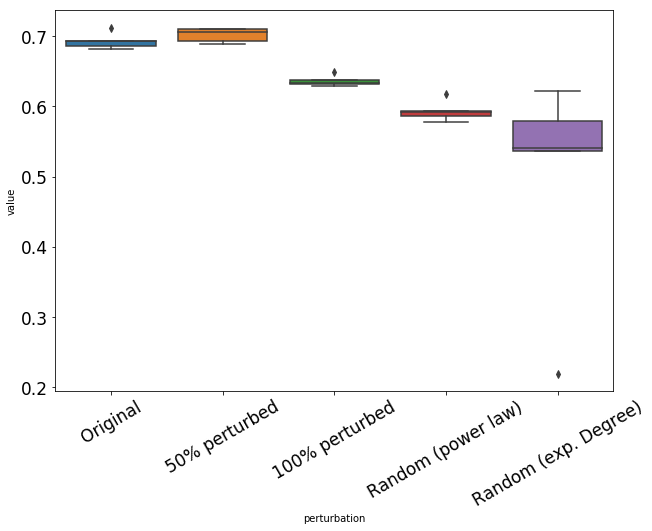

In [59]:
metrics = get_all_metrics(perturbation_folder, func=GCN_performance, kind='aupr', cv_auc_vals=True)
plot_curve(metrics, kind='box', figsize=(10, 7), ticksize=17, label_rotation=30,
           save_path=os.path.join(perturbation_folder, 'perturbations_violinplot.svg'))

## All Perturbations Simultaneously

In [5]:
metrics_features = get_all_metrics('../data/GCN/training/2019_08_26_11_26_22/', func=GCN_performance, kind='aupr', cv_auc_vals=True)
metrics_network = get_all_metrics('../data/GCN/training/2019_08_27_11_32_33/', func=GCN_performance, kind='aupr', cv_auc_vals=True)
metrics_netfeat = get_all_metrics('../data/GCN/training/2019_08_29_11_25_15/', func=GCN_performance, kind='aupr', cv_auc_vals=True)

0_feature_perturbation
Network: Original	AUPR: 0.6933613429711172
0_5_feature_perturbation
Network: 50% Edited	AUPR: 0.7019215754128152
1_feature_perturbation
Network: 100% Edited	AUPR: 0.6366390369749153
Random_powerlaw_feature_perturbation
Network: Random
(Power Law)	AUPR: 0.5936893593871682
Random_degreepreserved_feature_perturbation
Network: Random
(exp. Degree)	AUPR: 0.5000469168539297
0_perturbation
Network: Original	AUPR: 0.6954476507350471
0_5_perturbation
Network: 50% Edited	AUPR: 0.6233418634991323
1_perturbation
Network: 100% Edited	AUPR: 0.6233474841139144
Random_degreepreserved_perturbation
Network: Random
(exp. Degree)	AUPR: 0.614529516767129
Random_powerlaw_perturbation
Network: Random
(Power Law)	AUPR: 0.5809589620057498
0_networkfeature_perturbation
Network: Original	AUPR: 0.7017949312918444
0_5_networkfeature_perturbation
Network: 50% Edited	AUPR: 0.5865720660028892
1_networkfeature_perturbation
Network: 100% Edited	AUPR: 0.5873078180075019
Random_degreepreserved_netw

In [18]:
df_feat

,CV_0,CV_1,CV_2,CV_3,CV_4,perturbation,perturbation_name
0_feature_perturbation,0.692,0.682,0.712,0.694,0.687,Original,features
0_5_feature_perturbation,0.710,0.706,0.711,0.693,0.689,50% Edited,features
1_feature_perturbation,0.632,0.630,0.638,0.634,0.649,100% Edited,features
Random_powerlaw_feature_perturbation,0.618,0.587,0.593,0.577,0.593,Random\n(exp. Degree),features


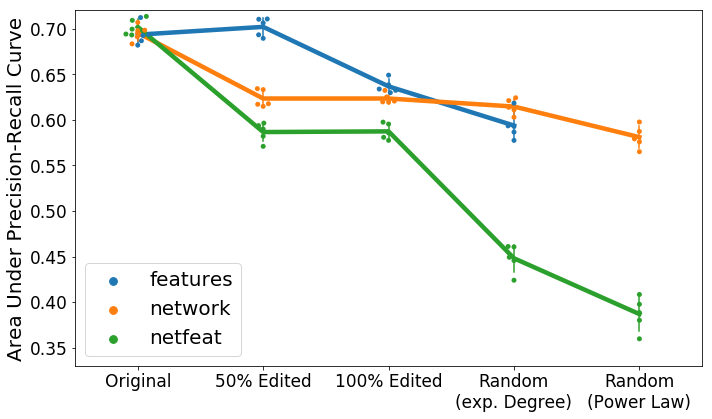

In [20]:
def make_df_from_metrics(metrics, perturbation_name='features'):
    df = pd.DataFrame([i[0] for i in metrics],
                      index=[i[1] for i in metrics],
                      columns=['CV_{}'.format(i) for i in range(len(metrics[0][0]))]
                     )
    df['perturbation'] = [_get_printable_name(i) for i in df.index]
    df['perturbation_name'] = perturbation_name
    return df

# construct DataFrames with performance per CV run and join together
df_feat = make_df_from_metrics(metrics_features, perturbation_name='features')

# remove one of the random feature vectors (confusing in the final plot)
df_feat = make_df_from_metrics(metrics_features, perturbation_name='features')
df_feat.drop('Random_degreepreserved_feature_perturbation', inplace=True)
df_feat.loc[df_feat.perturbation == 'Random\n(Power Law)', 'perturbation'] = 'Random\n(exp. Degree)'

# change order for line plot
df_feat = df_feat.loc[['0_feature_perturbation', '0_5_feature_perturbation', '1_feature_perturbation',
                       'Random_degreepreserved_feature_perturbation', 'Random_powerlaw_feature_perturbation'], :]
df_net = make_df_from_metrics(metrics_network, perturbation_name='network')
df_netfeat = make_df_from_metrics(metrics_netfeat, perturbation_name='netfeat')
all_metrics = pd.concat((df_feat, df_net, df_netfeat))

# plot
long = all_metrics.melt(id_vars=['perturbation', 'perturbation_name'])
fig = plt.figure(figsize=(10, 6))
sns.lineplot(data=long, x='perturbation', y='value', hue='perturbation_name', sort=False, err_style='bars', ci='sd', legend=False, lw=4.5)
sns.swarmplot(data=long, x='perturbation', y='value', hue='perturbation_name')#, color='white', edgecolor='darkgray')#, hue='variable')
plt.tick_params(axis='both', labelsize=17)
plt.tick_params(axis='x', labelrotation=0)
plt.xlabel(None)
plt.ylabel('Area Under Precision-Recall Curve', fontsize=20)
plt.legend(loc='lower left', fontsize=20)
plt.ylim([0.33, 0.72]) # to get rid of one outlier in the plot
fig.tight_layout()
fig.savefig('../data/simulation/perturbation_lineplot.svg')

0_feature_perturbation
Network: Original	AUPR: 0.7074690526299641
0_5_feature_perturbation
Network: 50% perturbed	AUPR: 0.7104859483637552
1_feature_perturbation
Network: 100% perturbed	AUPR: 0.6385310223970834
Random_powerlaw_feature_perturbation
Network: Random (power law)	AUPR: 0.6200070944350673
Random_degreepreserved_feature_peprturbation
Network: Random (exp. Degree)	AUPR: 0.673909947194718


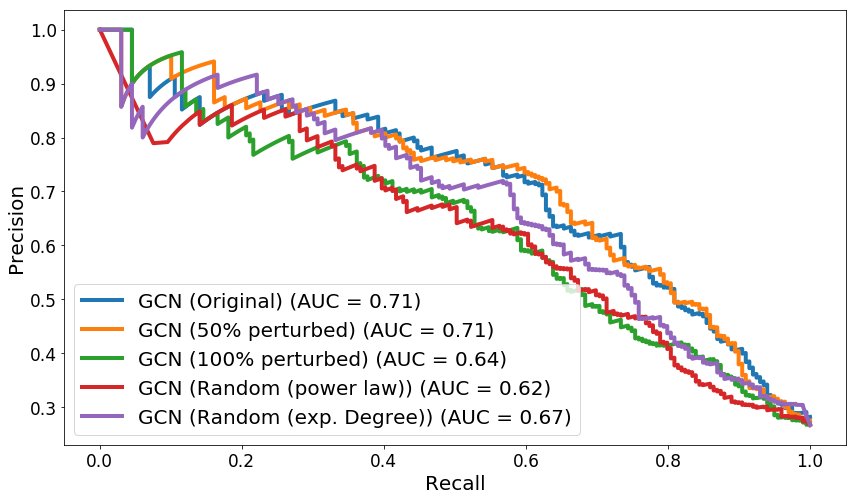

In [48]:
plot_curve(get_all_metrics(perturbation_folder, GCN_performance, 'aupr'),
           method_name='GCN', kind='PR', save_path=os.path.join(perturbation_folder, 'perturbations_PR.svg'))

In [27]:
m = get_all_metrics(perturbation_folder, GCN_performance, 'aupr')

0_networkfeature_perturbation
(746, 5) 199
Network: Original	AUPR: 0.716720627825418
0_5_networkfeature_perturbation
(746, 5) 199
Network: 50% perturbed	AUPR: 0.5823631616331997
1_networkfeature_perturbation
(746, 5) 199
Network: 100% perturbed	AUPR: 0.5926452287147469
Random_degreepreserved_networkfeature_perturbation
(746, 5) 199
Network: Random (exp. Degree)	AUPR: 0.49474305711692323
Random_powerlaw_networkfeature_perturbation
(746, 5) 199
Network: Random (power law)	AUPR: 0.4018457532846418


## Random Forest Classifier on perturbed data

0_perturbation
Network: Original	AUPR: 0.5277335484229813
0_5_perturbation
Network: 50% perturbed	AUPR: 0.5352732970896535
1_perturbation
Network: 100% perturbed	AUPR: 0.5385750841729334
Random_degreepreserved_perturbation
Network: Random (exp. Degree)	AUPR: 0.5290627785560543
Random_powerlaw_perturbation
Network: Random (power law)	AUPR: 0.5410969069827125


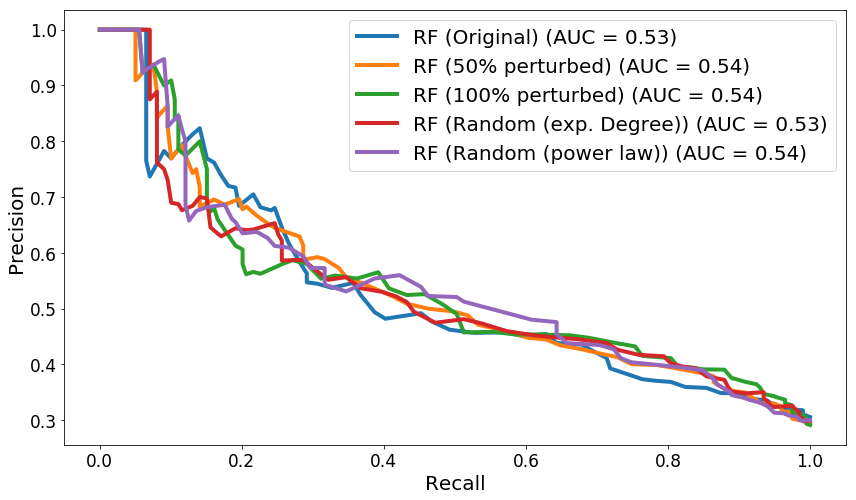

In [20]:
plot_curve(get_all_metrics(perturbation_folder, rf_performance, 'aupr'), 'RF')

## PageRank algorithm on perturbed data

0_networkfeature_perturbation


/home/sasse/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Network: Original	AUPR: 0.5937367056766978
0_5_networkfeature_perturbation
Network: 50% perturbed	AUPR: 0.5956419461293987
1_networkfeature_perturbation
Network: 100% perturbed	AUPR: 0.5944507273297337
Random_degreepreserved_networkfeature_perturbation
Network: Random (exp. Degree)	AUPR: 0.5906089517740564
Random_powerlaw_networkfeature_perturbation
Network: Random (power law)	AUPR: 0.5480496858654611


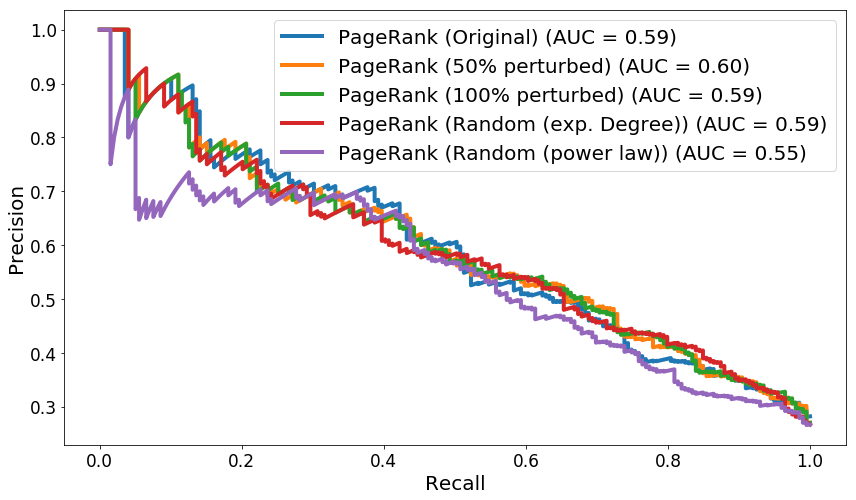

In [5]:
plot_curve(get_all_metrics(perturbation_folder, pagerank_performance), 'PageRank')

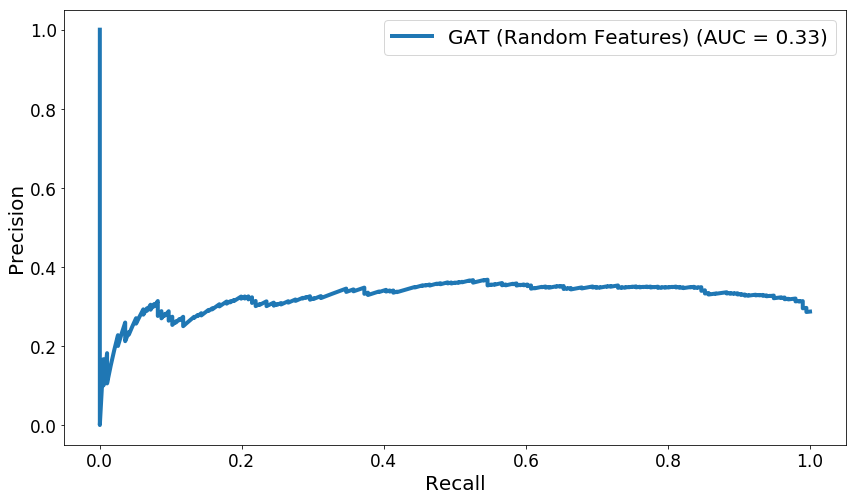

In [80]:
gat_perf = np.load('../data/pancancer/gat_results/results_GAT_IREF_randomfeatures.npy')
gat_perf = gat_perf.reshape(gat_perf.shape[1], gat_perf.shape[2])
args, data_file = gcnIO.load_hyper_params(os.path.join(perturbation_folder, 'Random_degreepreserved_feature_perturbation'))
data = gcnIO.load_hdf_data(data_file)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
gat_results_test = gat_perf[test_mask == 1, :]

perf_list = [list(_performance(y_true=y_test[test_mask == 1, 0], y_score=gat_results_test[:, 1], metric='aupr')) + ['Random Features']]
plot_curve(perf_list, 'GAT')

../data/GCN/training/perturbation_features_old/Random_powerlaw_feature_perturbation


/home/sasse/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


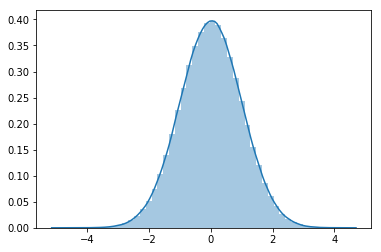

In [6]:
test_dir = os.path.join(perturbation_folder, 'Random_powerlaw_feature_perturbation')
print (test_dir)
args, data_file = gcnIO.load_hyper_params(test_dir)
data = gcnIO.load_hdf_data(data_file)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
sns.distplot(features.reshape(-1))

A = pd.DataFrame(network, index=node_names[:, 1], columns=node_names[:, 1])
adj = nx.from_pandas_adjacency(A)
cancer_genes = node_names[np.logical_or(np.logical_or(y_train.reshape(-1), y_val.reshape(-1)), y_test.reshape(-1)), 1]

In [7]:
# get the NCG cancer genes
known_cancer_genes = []
candidate_cancer_genes = []
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])
known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

digsee_genes = []
# add expression literature evidence (digSEE)
with open('../data/pancancer/digSEE/expression/pan_cancer_genes.txt', 'r') as f:
    for line in f.readlines():
        digsee_genes.append(line.strip())
# add mutational literature evidence (digSEE)
with open('../data/pancancer/digSEE/mutation/pan_cancer_genes.txt', 'r') as f:
    for line in f.readlines():
        digsee_genes.append(line.strip())
# add methylation literature evidence (digSEE)
with open('../data/pancancer/digSEE/methylation/pan_cancer_genes.txt', 'r') as f:
    for line in f.readlines():
        digsee_genes.append(line.strip())

In [8]:
len([i for i in cancer_genes if i in known_cancer_genes]), len(cancer_genes), len(known_cancer_genes), len(known_cancer_genes_innet)

(640, 785, 711, 640)

In [9]:
np.logical_and(np.logical_or(train_mask, val_mask), test_mask).any()

False

In [10]:
test_dir

'../data/GCN/training/perturbation_features_old/Random_powerlaw_feature_perturbation'

In [11]:
cancer_gene_neighbors = {}
for node in adj.nodes():
    num_cancer_genes = len([i for i in adj.neighbors(node) if i in cancer_genes]) / len([i for i in adj.neighbors(node)])
    cancer_gene_neighbors[node] = num_cancer_genes

In [12]:
nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('Name')
nodes['Cancer_Neighbors'] = nodes.index.map(cancer_gene_neighbors)
nodes['Degree'] = network.sum(axis=0)
predictions = postprocessing.load_predictions(test_dir)
nodes_with_pred = nodes.merge(predictions, left_index=True, right_on='Name')
nodes_with_pred['label_test'] = y_test
nodes_with_pred['log_prob'] = np.log2(nodes_with_pred.Prob_pos)

In [13]:
#betweenness = nx.algorithms.centrality.approximate_current_flow_betweenness_centrality(G=adj)

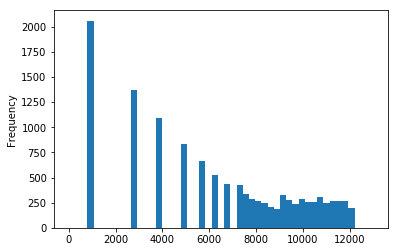

In [14]:
#nodes_with_pred['Betweenness'] = nodes_with_pred.Name.map(betweenness)
#nodes_with_pred['Betweenness_Rank'] = nodes_with_pred.Betweenness.rank()
nodes_with_pred['Degree_Rank'] = nodes_with_pred.Degree.rank()
nodes_with_pred['Prob_Rank'] = nodes_with_pred.Prob_pos.rank()
nodes_with_pred.Degree_Rank.plot(kind='hist', bins=np.linspace(0, 13000, 50))

Text(0.5, 1.0, 'Correlation between Node Degree and GCN Probabilities (R=0.76)')

/home/sasse/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


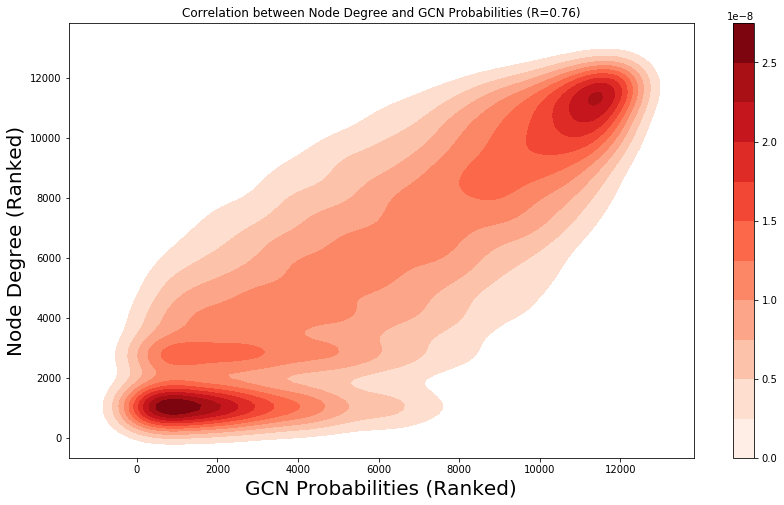

In [15]:
fig = plt.figure(figsize=(14, 8))
cmap = 'Reds'
sns.kdeplot(nodes_with_pred.Prob_Rank, nodes_with_pred.Degree_Rank, cmap=cmap, shade=True, shade_lowest=False, cbar=True)
plt.xlabel('GCN Probabilities (Ranked)', fontsize=20)
plt.ylabel('Node Degree (Ranked)', fontsize=20)
plt.title('Correlation between Node Degree and GCN Probabilities (R={0:.2f})'.format(nodes_with_pred.Degree_Rank.corr(nodes_with_pred.Prob_Rank)))

<Figure size 1008x576 with 0 Axes>

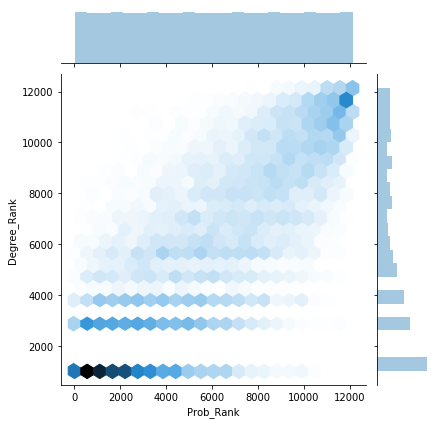

In [16]:
fig = plt.figure(figsize=(14, 8))

sns.jointplot(data=nodes_with_pred, x='Prob_Rank', y='Degree_Rank', kind='hex')
                #s=100, alpha=.7)#, palette=plt.get_cmap("Blues"))

In [17]:
nodes_with_pred['labeltype'] = 'No Label'
nodes_with_pred.loc[nodes_with_pred.Name.isin(known_cancer_genes), 'labeltype'] = 'NCG (Known)'
nodes_with_pred.loc[nodes_with_pred.Name.isin(candidate_cancer_genes), 'labeltype'] = 'NCG (Candidates)'
nodes_with_pred.loc[nodes_with_pred.Name.isin(digsee_genes), 'labeltype'] = 'DigSEE'

(20.0, 19.0)

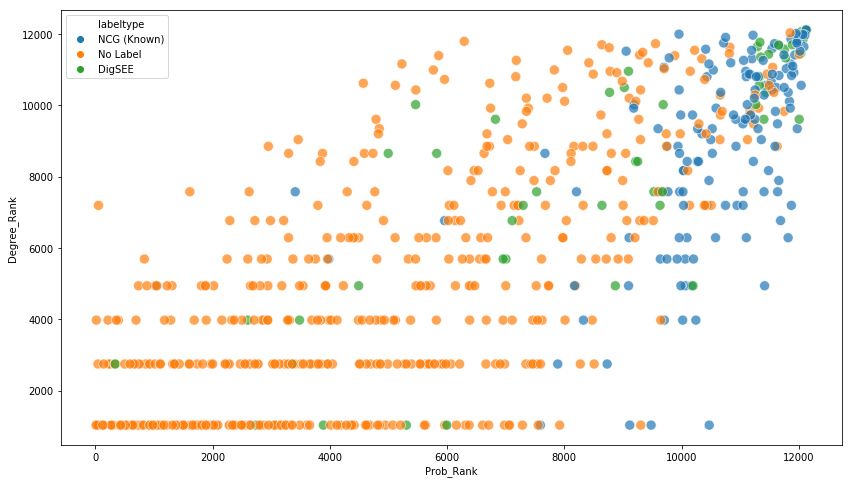

In [38]:
nodeprepd_test = nodes_with_pred[test_mask]
fig = plt.figure(figsize=(14, 8))
sns.scatterplot(data=nodeprepd_test, x='Prob_Rank', hue='labeltype', y='Degree_Rank', #style='label',
                s=100, alpha=.7)#, palette=plt.get_cmap("coolwarm"))
nodes_with_pred[nodes_with_pred.labeltype == 'DigSEE'].Degree.median(), nodes_with_pred[nodes_with_pred.labeltype == 'NCG (Known)'].Degree.median()

In [39]:
nodes_with_pred[nodes_with_pred.label].Cancer_Neighbors.mean(), nodes_with_pred[nodes_with_pred.label].Prob_pos.mean()

(0.23591366722060883, 0.7564004110827863)

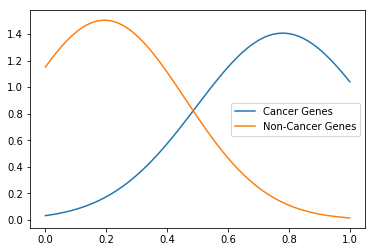

In [41]:
nodeprepd_test[~nodeprepd_test.label].Prob_pos.std(), nodeprepd_test[nodeprepd_test.label].Prob_pos.std()

import scipy.stats as stats

x = np.linspace(0, 1, 100)
test_neg = nodeprepd_test[~nodeprepd_test.label].Prob_pos
test_pos = nodeprepd_test[nodeprepd_test.label].Prob_pos
plt.plot(x, stats.norm.pdf(x, test_pos.mean(), test_pos.std()), label='Cancer Genes')
plt.plot(x, stats.norm.pdf(x, test_neg.mean(), test_neg.std()), label='Non-Cancer Genes')
plt.legend()

In [43]:
nodes_with_pred[nodes_with_pred.label].Prob_pos.mean(), nodes_with_pred[~nodes_with_pred.label].Prob_pos.mean()

(0.7564004110827863, 0.29297089156005784)

668 668 668 667
0.8128056529137816 0.6903931347267644


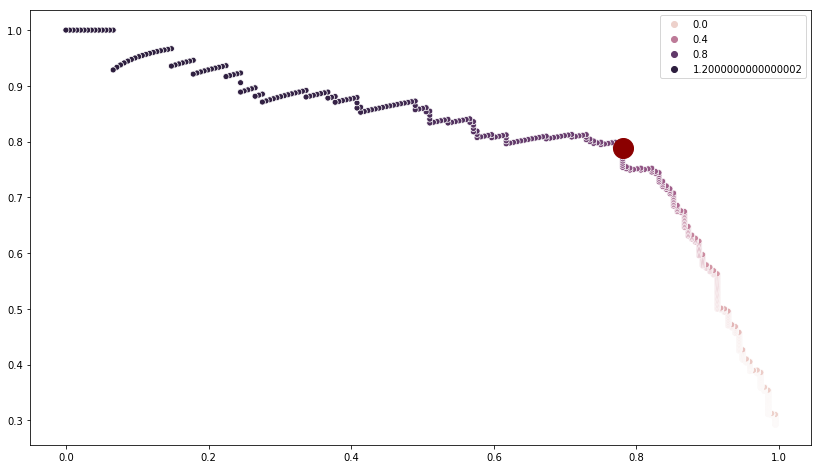

In [44]:
def _get_optimal_cutoff(pred, node_names, test_mask, y_test):
    pred_test = pred[pred.Name.isin(node_names[test_mask, 1])]
    y_true = pred_test.label
    y_score = pred_test.Prob_pos
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    aupr = average_precision_score(y_true=y_true, y_score=y_score)
    pr = pr[1:]
    rec = rec[1:]
    thresholds = thresholds[1:]
    distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
    idx = np.argmin(distances)
    print (len(distances), len(pr), len(rec), len(thresholds))
    best_threshold = thresholds[idx]
    return best_threshold, aupr, pr, rec, thresholds, idx

best_thr, aupr, pr, rec, all_thr, idx = _get_optimal_cutoff(nodes_with_pred, node_names, test_mask, y_test)
print (aupr, best_thr)
fig = plt.figure(figsize=(14, 8))
sns.scatterplot(x=rec, y=pr, hue=[0] + all_thr.tolist())
plt.plot(rec[idx], pr[idx], marker='o', label='point', ms=20, color='darkred')

In [45]:
nodes_with_pred[nodes_with_pred.Prob_pos >= best_thr].shape

(2649, 13)

In [46]:
A.loc[A['CRK'] == 1].index

Index(['ABAT', 'ABI1', 'ABL1', 'ABL2', 'AFF2', 'AGPAT4', 'AIRE', 'AKAP2',
       'AKAP6', 'APOL5',
       ...
       'TNK2', 'TP53BP2', 'TPX2', 'TRIM39', 'UBE2J1', 'VAV1', 'WASL', 'WEE1',
       'XPO1', 'ZAP70'],
      dtype='object', length=167)